# Gold Price (GC=F) Prediction 

The goal of this project is to predict the future price of gold commodity using features available currently. 

In [1]:
include_indicators = []
include_tech_features = []
tickers = []

include_indicators = ['bollinger_bands', 'RSI', 'daily_return', 'ROC', 'MACD', 'on_balance_volume',]
#include_indicators = ['bollinger_bands', 'RSI', 'daily_return', 'sharpe_ratio', 'ROC', 'MACD', 'on_balance_volume',]

include_tech_features = ['bollinger_num_hband', 'bollinger_num_lband', 'max_price_pct', 'min_price_pct',
                         'avg_price', 'max_price', 'min_price']

tickers = ['DX-Y.NYB', 'BTC-USD']
#tickers = ['DX-Y.NYB', 'BTC-USD', "SPX", "SI=F", "CL=F",]

n_future_days = 7
seed = 4

gold_ticker = 'GC=F'
label_name = 'Future'
label_pct = False

# date range of data to collect
data_start_date = '2020-02-17'
data_end_date = '2020-11-15'

# parameters
params = {
    'annual_rfr': 0.01,
    'annual_sf': 252,
    'boll_n_days': 20,
    'boll_n_std': 2,
    'rsi_n_days': 10,
    'roc_n_days': 10,
    'sharpe_n_days': 20,
    'macd_n_short': 10,
    'macd_n_long': 20,
    'macd_n_signal': 5,
}
window_size = 20

In [2]:
!pip install yfinance
!pip install ta

In [3]:
import yfinance as yf
import ta

from ta_pipeline import calculate_technical_indicators, calculate_technical_features, get_pct_change
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib

from IPython.display import display 

import warnings
warnings.filterwarnings('ignore')
import os
os.getcwd()

C:\Users\Arnold\.conda\envs\base-streamlit\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


'C:\\Users\\Arnold\\Desktop\\future_alchemy-master\\future_alchemy-master'

## Data Extraction

We first download the gold prices for our date range using `yfinance`, which sources data from Yahoo! Finance.

In [4]:
df = yf.download(gold_ticker, data_start_date, data_end_date, auto_adjust=True)
#df = df.drop(columns=['Open', 'High', 'Low', 'Volume'])
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2020-02-18,1579.800049,1604.300049,1579.800049,1600.000000,310
2020-02-19,1600.599976,1610.500000,1599.699951,1607.500000,542
2020-02-20,1606.500000,1621.000000,1603.000000,1616.599976,117
2020-02-21,1619.300049,1645.000000,1619.300049,1644.599976,186
2020-02-23,1656.000000,1684.099976,1654.599976,1667.099976,1560329
...,...,...,...,...,...
2020-11-09,1955.599976,1963.199951,1847.099976,1853.199951,745
2020-11-10,1879.300049,1885.300049,1871.199951,1875.400024,276
2020-11-11,1878.800049,1878.800049,1855.500000,1860.699951,222


We also get the prices for other tickers we want to observe.

In [5]:
if tickers != []:
    
    ticker_dfs = {}
    
    for ticker in tickers:
        ticker_dfs[ticker] = yf.download(ticker, data_start_date, data_end_date, auto_adjust=True)
        #df = df.drop(columns=['Open', 'High', 'Low', 'Volume'])

ticker_dfs

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


{'DX-Y.NYB':                  Open       High        Low      Close  Volume
 Date                                                          
 2020-02-18  99.190002  99.470001  99.139999  99.459999       0
 2020-02-19  99.430000  99.720001  99.379997  99.599998       0
 2020-02-20  99.540001  99.910004  99.529999  99.870003       0
 2020-02-21  99.860001  99.870003  99.230003  99.260002       0
 2020-02-24  99.339996  99.639999  99.110001  99.290001       0
 ...               ...        ...        ...        ...     ...
 2020-11-09  92.239998  92.959999  92.129997  92.730003       0
 2020-11-10  92.760002  92.970001  92.599998  92.750000       0
 2020-11-11  92.699997  93.209999  92.610001  93.040001       0
 2020-11-12  93.010002  93.139999  92.779999  92.959999       0
 2020-11-13  92.949997  93.010002  92.709999  92.760002       0
 
 [195 rows x 5 columns],
 'BTC-USD':                     Open          High           Low         Close  \
 Date                                          

In [6]:
#ta_df = df.copy()
#ta.add_all_ta_features(ta_df, open="Open", close="Close", high="High", low="Low", volume="Volume")
#df

### Technical Indicators
We then compute the values of the technical indicators we included.

In [7]:
ta_df = df.copy()
ta_df = calculate_technical_indicators(ta_df, include_indicators, params, verbose=True)
ta_df

Bollinger bands...
RSI...
Daily return...
ROC...
Moving Average Convergence Divergence...
On-Balance Volume...


,Open,High,Low,Close,Volume,boll_mavg,boll_hband,boll_lband,boll_hband_ind,boll_lband_ind,boll_bandwidth,RSI,daily_return,ROC,MACD,on_balance_volume
Date,,,,,,,,,,,,,,,,
2020-02-18,1579.800049,1604.300049,1579.800049,1600.000000,310,NaN,NaN,NaN,0.0,0.0,NaN,NaN,-10.771547,NaN,NaN,310
2020-02-19,1600.599976,1610.500000,1599.699951,1607.500000,542,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.468750,NaN,NaN,852
2020-02-20,1606.500000,1621.000000,1603.000000,1616.599976,117,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.566095,NaN,NaN,969
2020-02-21,1619.300049,1645.000000,1619.300049,1644.599976,186,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.732030,NaN,NaN,1155
2020-02-23,1656.000000,1684.099976,1654.599976,1667.099976,1560329,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.368114,NaN,NaN,1561484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-09,1955.599976,1963.199951,1847.099976,1853.199951,745,1900.565002,1945.751775,1855.378230,0.0,1.0,4.755088,38.710915,-4.978726,-2.519595,-0.384811,14227407
2020-11-10,1879.300049,1885.300049,1871.199951,1875.400024,276,1899.910004,1946.144955,1853.675053,0.0,0.0,4.867067,44.467348,1.197932,-1.398527,-2.591532,14227683
2020-11-11,1878.800049,1878.800049,1855.500000,1860.699951,222,1897.879999,1947.157643,1848.602355,0.0,0.0,5.192915,41.593162,-0.783837,-2.207390,-5.452937,14227461


In [8]:
if tickers != []:
    ticker_ta_dfs = {}
    for ticker in tickers:
        print(ticker)
        ticker_ta_dfs[ticker] = calculate_technical_indicators(ticker_dfs[ticker], include_indicators, params, verbose=False)

DX-Y.NYB
BTC-USD


### Technical Features
We use the technical indicators to compute technical features.  The following features are computed from the technical indicators for a window of `window_size`.

We also add as a feature the previous percentage change of the days `n_future_days` before.  That is, if `n_future_days = 2` and today (after closing) is 2020-07-17, then we compute the percentage change from 2020-07-15 to 2020-07-17 and include this as a feature for 2020-07-17. 

In [9]:
tf_df = ta_df.copy()
tf_df = calculate_technical_features(tf_df, include_tech_features, window_size, verbose=True)
tf_df = get_pct_change(tf_df, n=n_future_days)
tf_df

Average Price...
Max Price...
Min Price...
Max Price Pct...
Min Price Pct...
Bollinger Num HBands...
Bollinger Num LBands...
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'boll_mavg', 'boll_hband',
       'boll_lband', 'boll_hband_ind', 'boll_lband_ind', 'boll_bandwidth',
       'RSI', 'daily_return', 'ROC', 'MACD', 'on_balance_volume', 'avg_close',
       'max_close', 'min_close', 'max_close_pct', 'min_close_pct',
       'boll_hband_num', 'boll_lband_num', 'pct_change'],
      dtype='object')


,Open,High,Low,Close,Volume,boll_mavg,boll_hband,boll_lband,boll_hband_ind,boll_lband_ind,...,MACD,on_balance_volume,avg_close,max_close,min_close,max_close_pct,min_close_pct,boll_hband_num,boll_lband_num,pct_change
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,1579.800049,1604.300049,1579.800049,1600.000000,310,NaN,NaN,NaN,0.0,0.0,...,NaN,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-19,1600.599976,1610.500000,1599.699951,1607.500000,542,NaN,NaN,NaN,0.0,0.0,...,NaN,852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-20,1606.500000,1621.000000,1603.000000,1616.599976,117,NaN,NaN,NaN,0.0,0.0,...,NaN,969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-21,1619.300049,1645.000000,1619.300049,1644.599976,186,NaN,NaN,NaN,0.0,0.0,...,NaN,1155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-23,1656.000000,1684.099976,1654.599976,1667.099976,1560329,NaN,NaN,NaN,0.0,0.0,...,NaN,1561484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-09,1955.599976,1963.199951,1847.099976,1853.199951,745,1900.565002,1945.751775,1855.378230,0.0,1.0,...,-0.384811,14227407,1900.565002,1950.300049,1853.199951,1.026169,0.975078,2.0,3.0,0.993353
2020-11-10,1879.300049,1885.300049,1871.199951,1875.400024,276,1899.910004,1946.144955,1853.675053,0.0,0.0,...,-2.591532,14227683,1899.910004,1950.300049,1853.199951,1.026522,0.975415,2.0,3.0,0.998935
2020-11-11,1878.800049,1878.800049,1855.500000,1860.699951,222,1897.879999,1947.157643,1848.602355,0.0,0.0,...,-5.452937,14227461,1897.879999,1950.300049,1853.199951,1.027620,0.976458,2.0,3.0,0.984289


In [10]:
if tickers != []:
    ticker_tf_dfs = {}
    for ticker in tickers:
        print(ticker)
        ticker_tf_dfs[ticker] = calculate_technical_features(ticker_ta_dfs[ticker], include_tech_features,
                                                            window_size, verbose=False)

ticker_tf_dfs

DX-Y.NYB
BTC-USD


{'DX-Y.NYB':                  Open       High        Low      Close  Volume  boll_mavg  \
 Date                                                                        
 2020-02-18  99.190002  99.470001  99.139999  99.459999       0        NaN   
 2020-02-19  99.430000  99.720001  99.379997  99.599998       0        NaN   
 2020-02-20  99.540001  99.910004  99.529999  99.870003       0        NaN   
 2020-02-21  99.860001  99.870003  99.230003  99.260002       0        NaN   
 2020-02-24  99.339996  99.639999  99.110001  99.290001       0        NaN   
 ...               ...        ...        ...        ...     ...        ...   
 2020-11-09  92.239998  92.959999  92.129997  92.730003       0  93.261000   
 2020-11-10  92.760002  92.970001  92.599998  92.750000       0  93.222001   
 2020-11-11  92.699997  93.209999  92.610001  93.040001       0  93.205001   
 2020-11-12  93.010002  93.139999  92.779999  92.959999       0  93.160001   
 2020-11-13  92.949997  93.010002  92.709999  92.760

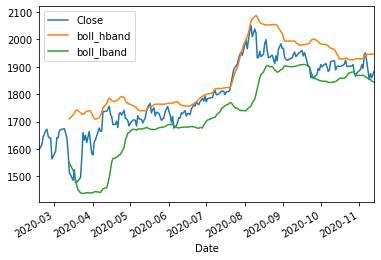

In [11]:
ta_df[['Close', 'boll_hband', 'boll_lband']].plot()

## Labeling
We label our dataset with the closing price from `n_future_days` in advance. We also compute the difference between this future closing price and the current closing price.

Note that because percent change is actually more important than the magnitude change of the price, we convert the closing price from `n_future_days` to a percentage of the current closing price.  This allows us to optimize our models using MSE or MAE as loss functions directly, without having to implement MAPE, which is not supported by Sci-Kit Learn.

In [12]:
data_df = tf_df.copy()
data_df[label_name] = data_df['Close']
data_df[label_name] = data_df[label_name].shift(periods=-1*n_future_days)
if label_pct:
    data_df[label_name] = data_df[label_name] / data_df['Close']

#data_df[label_name+'Diff'] = data_df[label_name] - data_df['Close']
data_df

,Open,High,Low,Close,Volume,boll_mavg,boll_hband,boll_lband,boll_hband_ind,boll_lband_ind,...,on_balance_volume,avg_close,max_close,min_close,max_close_pct,min_close_pct,boll_hband_num,boll_lband_num,pct_change,Future
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,1579.800049,1604.300049,1579.800049,1600.000000,310,NaN,NaN,NaN,0.0,0.0,...,310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1640.000000
2020-02-19,1600.599976,1610.500000,1599.699951,1607.500000,542,NaN,NaN,NaN,0.0,0.0,...,852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1640.000000
2020-02-20,1606.500000,1621.000000,1603.000000,1616.599976,117,NaN,NaN,NaN,0.0,0.0,...,969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1564.099976
2020-02-21,1619.300049,1645.000000,1619.300049,1644.599976,186,NaN,NaN,NaN,0.0,0.0,...,1155,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1592.300049
2020-02-23,1656.000000,1684.099976,1654.599976,1667.099976,1560329,NaN,NaN,NaN,0.0,0.0,...,1561484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1642.099976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-09,1955.599976,1963.199951,1847.099976,1853.199951,745,1900.565002,1945.751775,1855.378230,0.0,1.0,...,14227407,1900.565002,1950.300049,1853.199951,1.026169,0.975078,2.0,3.0,0.993353,NaN
2020-11-10,1879.300049,1885.300049,1871.199951,1875.400024,276,1899.910004,1946.144955,1853.675053,0.0,0.0,...,14227683,1899.910004,1950.300049,1853.199951,1.026522,0.975415,2.0,3.0,0.998935,NaN
2020-11-11,1878.800049,1878.800049,1855.500000,1860.699951,222,1897.879999,1947.157643,1848.602355,0.0,0.0,...,14227461,1897.879999,1950.300049,1853.199951,1.027620,0.976458,2.0,3.0,0.984289,NaN


## Combine DataFrames from other Tickers
We combine the Gold dataframe with the dataframe of the other tickers by joining by date.

In [13]:
joined_data_df = data_df.copy()
for ticker in tickers:
    ticker_tf_dfs[ticker].columns = [ticker+"_"+col_name for col_name in ticker_tf_dfs[ticker].columns]
    joined_data_df = joined_data_df.join(ticker_tf_dfs[ticker])

display(joined_data_df.columns)
display(len(joined_data_df.columns))
#joined_data_df.to_csv("joined_data_df.csv")

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'boll_mavg', 'boll_hband',
       'boll_lband', 'boll_hband_ind', 'boll_lband_ind', 'boll_bandwidth',
       'RSI', 'daily_return', 'ROC', 'MACD', 'on_balance_volume', 'avg_close',
       'max_close', 'min_close', 'max_close_pct', 'min_close_pct',
       'boll_hband_num', 'boll_lband_num', 'pct_change', 'Future',
       'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'DX-Y.NYB_Close',
       'DX-Y.NYB_Volume', 'DX-Y.NYB_boll_mavg', 'DX-Y.NYB_boll_hband',
       'DX-Y.NYB_boll_lband', 'DX-Y.NYB_boll_hband_ind',
       'DX-Y.NYB_boll_lband_ind', 'DX-Y.NYB_boll_bandwidth', 'DX-Y.NYB_RSI',
       'DX-Y.NYB_daily_return', 'DX-Y.NYB_ROC', 'DX-Y.NYB_MACD',
       'DX-Y.NYB_on_balance_volume', 'DX-Y.NYB_avg_close',
       'DX-Y.NYB_max_close', 'DX-Y.NYB_min_close', 'DX-Y.NYB_max_close_pct',
       'DX-Y.NYB_min_close_pct', 'DX-Y.NYB_boll_hband_num',
       'DX-Y.NYB_boll_lband_num', 'BTC-USD_Open', 'BTC-USD_High',
       'BTC-USD_Low', 'BTC-US

71

We make date a feature by changing it to a numerical value.

In [14]:
joined_data_df['day'] = np.arange(len(joined_data_df))
joined_data_df

,Open,High,Low,Close,Volume,boll_mavg,boll_hband,boll_lband,boll_hband_ind,boll_lband_ind,...,BTC-USD_MACD,BTC-USD_on_balance_volume,BTC-USD_avg_close,BTC-USD_max_close,BTC-USD_min_close,BTC-USD_max_close_pct,BTC-USD_min_close_pct,BTC-USD_boll_hband_num,BTC-USD_boll_lband_num,day
Date,,,,,,,,,,,,,,,,,,,,,
2020-02-18,1579.800049,1604.300049,1579.800049,1600.000000,310,NaN,NaN,NaN,0.0,0.0,...,NaN,93269322365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2020-02-19,1600.599976,1610.500000,1599.699951,1607.500000,542,NaN,NaN,NaN,0.0,0.0,...,NaN,46277302656,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2020-02-20,1606.500000,1621.000000,1603.000000,1616.599976,117,NaN,NaN,NaN,0.0,0.0,...,NaN,1352042420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2020-02-21,1619.300049,1645.000000,1619.300049,1644.599976,186,NaN,NaN,NaN,0.0,0.0,...,NaN,42282589932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2020-02-23,1656.000000,1684.099976,1654.599976,1667.099976,1560329,NaN,NaN,NaN,0.0,0.0,...,NaN,47629750539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-09,1955.599976,1963.199951,1847.099976,1853.199951,745,1900.565002,1945.751775,1855.378230,0.0,1.0,...,740.603956,796833072867,13889.474072,15579.848633,12823.689453,1.121702,0.923267,6.0,0.0,209
2020-11-10,1879.300049,1885.300049,1871.199951,1875.400024,276,1899.910004,1946.144955,1853.675053,0.0,0.0,...,721.865697,771258134724,14012.834717,15579.848633,12931.539062,1.111827,0.922835,5.0,0.0,210
2020-11-11,1878.800049,1878.800049,1855.500000,1860.699951,222,1897.879999,1947.157643,1848.602355,0.0,0.0,...,731.030393,801030509658,14149.607129,15701.339844,12931.539062,1.109666,0.913915,4.0,0.0,211


## Analysis
We analyze some statistical properties of our dataset as a sanity-check.

In [15]:
corr_df = joined_data_df.corrwith(other=data_df['Future']).to_frame()
corr_df.to_csv("correlation.csv")

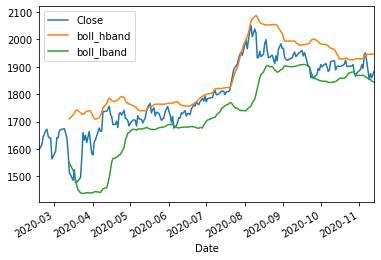

In [16]:
joined_data_df[['Close', 'boll_hband', 'boll_lband']].plot()

We fit the closing prices onto a polynomial function.

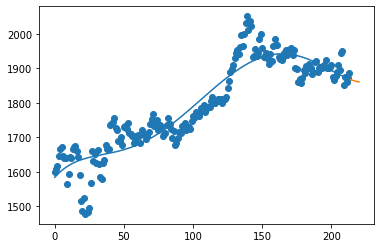

In [17]:
degree = 5
x = joined_data_df['day']
y = joined_data_df['Close']
poly_model = np.poly1d(np.polyfit(x, y, degree))

day_range = np.linspace(np.min(x), np.max(x), np.max(x)-np.min(x)+1)

plt.scatter(x, y)
plt.plot(day_range, poly_model(day_range)) 

new_day_range = np.linspace(np.max(x)+1, np.max(x)+7, 7)
plt.plot(new_day_range, poly_model(new_day_range))

## Dataset Split
We split our dataset into 3 groups: training (70%), validation (15%), and testing (15%). 

Because the data is inherently a time-series, we select the training data to be the earliest 70% of the data, whereas the validation and testing data are from the latest 30%.

In [18]:
train_valid_test_ratio = [0.7, 0.15, 0.15]

In [19]:
nan_columns = joined_data_df.columns.to_list()
nan_columns.remove(label_name)
joined_data_df = joined_data_df.dropna(axis=0, subset=nan_columns)
#joined_data_df = joined_data_df.dropna(axis=0, how='any')
joined_data_df = joined_data_df.sort_values(by=['Date'])
joined_data_df.to_csv('feats_joined_data_df.csv')
joined_data_df = joined_data_df.dropna(axis=0, how='any')
joined_data_df.to_csv('joined_data_df.csv')
joined_data_df

,Open,High,Low,Close,Volume,boll_mavg,boll_hband,boll_lband,boll_hband_ind,boll_lband_ind,...,BTC-USD_MACD,BTC-USD_on_balance_volume,BTC-USD_avg_close,BTC-USD_max_close,BTC-USD_min_close,BTC-USD_max_close_pct,BTC-USD_min_close_pct,BTC-USD_boll_hband_num,BTC-USD_boll_lband_num,day
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-16,1569.099976,1569.099976,1452.099976,1485.900024,193,1623.890002,1725.160179,1522.619826,0.0,1.0,...,-968.433866,-359360501166,7747.898804,9122.545898,4970.788086,1.177422,0.641566,0.0,4.0,20
2020-03-17,1469.300049,1537.699951,1469.300049,1524.900024,122,1619.760004,1729.730444,1509.789563,0.0,0.0,...,-976.839677,-320737858231,7568.154150,9122.545898,4970.788086,1.205386,0.656803,0.0,4.0,21
2020-03-18,1537.500000,1542.000000,1477.300049,1477.300049,333,1612.795007,1739.113746,1486.476269,0.0,1.0,...,-965.038177,-282859057215,7390.851367,9122.545898,4970.788086,1.234302,0.672560,0.0,4.0,22
2020-03-19,1481.500000,1491.599976,1471.000000,1478.599976,262,1604.495007,1742.626154,1466.363860,0.0,0.0,...,-857.101826,-231858325418,7266.788257,9122.545898,4970.788086,1.255375,0.684042,0.0,4.0,23
2020-03-20,1483.500000,1484.000000,1483.500000,1484.000000,14,1595.340009,1739.786852,1450.893165,0.0,0.0,...,-761.702551,-177415349316,7146.751733,9122.545898,4970.788086,1.276460,0.695531,0.0,4.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-29,1876.099976,1879.800049,1858.800049,1865.599976,240,1900.979993,1929.833268,1872.126717,0.0,1.0,...,541.187874,767707634513,12235.380469,13654.218750,11296.361328,1.115962,0.923254,7.0,0.0,202
2020-10-30,1862.800049,1886.599976,1862.800049,1877.400024,725,1899.839996,1930.473221,1869.206772,0.0,0.0,...,540.695754,798289119713,12347.888525,13654.218750,11322.123047,1.105794,0.916928,6.0,0.0,203
2020-11-02,1872.900024,1894.699951,1872.900024,1890.400024,190,1898.734998,1929.054592,1868.415403,0.0,0.0,...,516.058565,773370271064,12683.045996,13780.995117,11322.123047,1.086568,0.892697,4.0,0.0,204


In [20]:
ordered_data_df = joined_data_df.copy()
num_rows = ordered_data_df.shape[0]

num_train_rows = int(num_rows * train_valid_test_ratio[0]) 
num_valid_rows = int((num_rows - num_train_rows) / 2)

train_df = ordered_data_df.iloc[0:num_train_rows]
valid_test_df = ordered_data_df.iloc[num_train_rows:]

split_ratio =  train_valid_test_ratio[1] / (train_valid_test_ratio[1]+train_valid_test_ratio[2]) 
valid_df, test_df = train_test_split(valid_test_df, test_size=split_ratio, random_state=seed)

train_df.to_csv('train_df.csv')
valid_test_df.to_csv('valid_test_df.csv')

We separate the features from the labels.

In [21]:
train_df = train_df.sort_values(by=['Date'], ascending=True)
valid_df = valid_df.sort_values(by=['Date'], ascending=True)
test_df = test_df.sort_values(by=['Date'], ascending=True)

train_labels, valid_labels, test_labels = np.array(train_df[label_name].to_list()), np.array(valid_df[label_name].to_list()), np.array(test_df[label_name].to_list())
unnorm_train_feats, unnorm_valid_feats, unnorm_test_feats = train_df.drop(columns=[label_name]), valid_df.drop(columns=[label_name]), test_df.drop(columns=[label_name])

display(unnorm_train_feats)
display(unnorm_train_feats.columns)
unnorm_train_feats.sort_values(by=['Date']).to_csv("unnorm_train_feats.csv")

,Open,High,Low,Close,Volume,boll_mavg,boll_hband,boll_lband,boll_hband_ind,boll_lband_ind,...,BTC-USD_MACD,BTC-USD_on_balance_volume,BTC-USD_avg_close,BTC-USD_max_close,BTC-USD_min_close,BTC-USD_max_close_pct,BTC-USD_min_close_pct,BTC-USD_boll_hband_num,BTC-USD_boll_lband_num,day
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-16,1569.099976,1569.099976,1452.099976,1485.900024,193,1623.890002,1725.160179,1522.619826,0.0,1.0,...,-968.433866,-359360501166,7747.898804,9122.545898,4970.788086,1.177422,0.641566,0.0,4.0,20
2020-03-17,1469.300049,1537.699951,1469.300049,1524.900024,122,1619.760004,1729.730444,1509.789563,0.0,0.0,...,-976.839677,-320737858231,7568.154150,9122.545898,4970.788086,1.205386,0.656803,0.0,4.0,21
2020-03-18,1537.500000,1542.000000,1477.300049,1477.300049,333,1612.795007,1739.113746,1486.476269,0.0,1.0,...,-965.038177,-282859057215,7390.851367,9122.545898,4970.788086,1.234302,0.672560,0.0,4.0,22
2020-03-19,1481.500000,1491.599976,1471.000000,1478.599976,262,1604.495007,1742.626154,1466.363860,0.0,0.0,...,-857.101826,-231858325418,7266.788257,9122.545898,4970.788086,1.255375,0.684042,0.0,4.0,23
2020-03-20,1483.500000,1484.000000,1483.500000,1484.000000,14,1595.340009,1739.786852,1450.893165,0.0,0.0,...,-761.702551,-177415349316,7146.751733,9122.545898,4970.788086,1.276460,0.695531,0.0,4.0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-20,1941.199951,1948.300049,1922.300049,1933.800049,106,1978.150000,2053.107273,1903.192727,0.0,0.0,...,269.474698,361147268325,11694.543750,12254.402344,11053.614258,1.047873,0.945194,2.0,0.0,151
2020-08-21,1941.000000,1945.000000,1908.900024,1934.599976,184,1977.204999,2053.839307,1900.570691,0.0,0.0,...,223.459602,337384842327,11686.188574,12254.402344,11053.614258,1.048623,0.945870,1.0,0.0,152
2020-08-23,1947.900024,1949.000000,1938.099976,1943.599976,515338,1977.269995,2053.787893,1900.752097,0.0,0.0,...,166.091075,339126970975,11738.524072,12254.402344,11205.892578,1.043947,0.954625,1.0,0.0,153


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'boll_mavg', 'boll_hband',
       'boll_lband', 'boll_hband_ind', 'boll_lband_ind', 'boll_bandwidth',
       'RSI', 'daily_return', 'ROC', 'MACD', 'on_balance_volume', 'avg_close',
       'max_close', 'min_close', 'max_close_pct', 'min_close_pct',
       'boll_hband_num', 'boll_lband_num', 'pct_change', 'DX-Y.NYB_Open',
       'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'DX-Y.NYB_Close', 'DX-Y.NYB_Volume',
       'DX-Y.NYB_boll_mavg', 'DX-Y.NYB_boll_hband', 'DX-Y.NYB_boll_lband',
       'DX-Y.NYB_boll_hband_ind', 'DX-Y.NYB_boll_lband_ind',
       'DX-Y.NYB_boll_bandwidth', 'DX-Y.NYB_RSI', 'DX-Y.NYB_daily_return',
       'DX-Y.NYB_ROC', 'DX-Y.NYB_MACD', 'DX-Y.NYB_on_balance_volume',
       'DX-Y.NYB_avg_close', 'DX-Y.NYB_max_close', 'DX-Y.NYB_min_close',
       'DX-Y.NYB_max_close_pct', 'DX-Y.NYB_min_close_pct',
       'DX-Y.NYB_boll_hband_num', 'DX-Y.NYB_boll_lband_num', 'BTC-USD_Open',
       'BTC-USD_High', 'BTC-USD_Low', 'BTC-USD_Close', 'BTC-US

## Feature and Label Normalization
We normalize each feature using the `MinMaxScaler`.

In [22]:
scaler = MinMaxScaler()

scaler.fit(unnorm_train_feats)
_ = joblib.dump(scaler, './models/scaler.pkl')

train_feats = scaler.transform(unnorm_train_feats)
valid_feats = scaler.transform(unnorm_valid_feats)
test_feats = scaler.transform(unnorm_test_feats)

In [23]:
train_feats.shape

(118, 71)

## Feature Selection

## Model Fitting and Evaluation

In [24]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [25]:
model_filenames = {
             'LinearRegression': "./models/lr.pkl",
             'Lasso': "./models/lasso.pkl",
             'Ridge': "./models/ridge.pkl",
             'DecisionTree': "./models/tree.pkl",
             'BagLinearRegression': "./models/lr_bag.pkl",
             'RandomForest': "./models/rf.pkl",
             'SVR': "./models/svr.pkl",
             'NeuralNetwork': "./models/nn.pkl"
}

if not os.path.exists('models'):
    os.makedirs('models')

top_model_configs = {}

### Baseline 
The average percent change (i.e., the label) provides to us an expectation of a stationary estimate.

'Mean: '

1795.941520044359

'   StD: '

115.81787686960014

(array([ 2.,  1.,  3.,  4.,  9., 14., 21., 11.,  7.,  9.,  1.,  1.,  1.,
         2.,  5., 12.,  5.,  5.,  2.,  3.]),
 array([1578.19995117, 1601.86495361, 1625.52995605, 1649.1949585 ,
        1672.85996094, 1696.52496338, 1720.18996582, 1743.85496826,
        1767.5199707 , 1791.18497314, 1814.84997559, 1838.51497803,
        1862.17998047, 1885.84498291, 1909.50998535, 1933.17498779,
        1956.83999023, 1980.50499268, 2004.16999512, 2027.83499756,
        2051.5       ]),
 <a list of 20 Patch objects>)

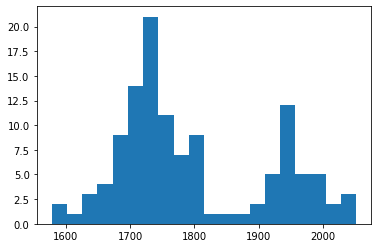

In [26]:
mean_label = np.mean(train_labels)
std_label = np.std(train_labels)

display("Mean: ", mean_label, "   StD: ", std_label)
plt.hist(train_labels, 20)

We calculate the mean absolute error of the percentage change if we use the mean as a constant prediction.

'Training MAE: 98.01578441730558  61.69835174169679'

'Valid MAE: 113.8584799556409  28.519095018345123'

(array([1., 0., 1., 0., 3., 1., 2., 1., 1., 1., 2., 1., 1., 3., 1., 1., 1.,
        2., 1., 1.]),
 array([ 57.25843113,  62.60843113,  67.95843113,  73.30843113,
         78.65843113,  84.00843113,  89.35843113,  94.70843113,
        100.05843113, 105.40843113, 110.75843113, 116.10843113,
        121.45843113, 126.80843113, 132.15843113, 137.50843113,
        142.85843113, 148.20843113, 153.55843113, 158.90843113,
        164.25843113]),
 <a list of 20 Patch objects>)

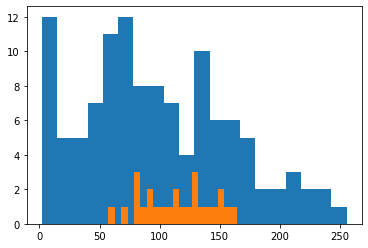

In [27]:
train_mean_abs_error = np.mean(np.abs(train_labels - mean_label))
train_std_abs_error = np.std(np.abs(train_labels - mean_label))
valid_mean_abs_error = np.mean(np.abs(valid_labels - mean_label))
valid_std_abs_error = np.std(np.abs(valid_labels - mean_label))
display("Training MAE: "+str(train_mean_abs_error)+"  "+str(train_std_abs_error))
display("Valid MAE: "+str(valid_mean_abs_error)+"  "+str(valid_std_abs_error))

plt.hist(np.abs(train_labels-mean_label), 20)
plt.hist(np.abs(valid_labels-mean_label), 20)

### Ridge Regression (L2)

In [28]:
alphas = list(np.arange(0, 100, 0.10))
results = {'alpha': [], 'valid_error': [], 'train_error': []}

min_error = None
lasso_coeff = None

for alpha in alphas:
    ridge_regressor = Ridge(alpha=alpha, random_state=seed).fit(train_feats, train_labels)

    train_predict = ridge_regressor.predict(train_feats)
    valid_predict = ridge_regressor.predict(valid_feats)
    valid_error = mean_absolute_error(valid_labels, valid_predict)
    train_error = mean_absolute_error(train_labels, train_predict)
    
    # update best performing hyperparamters
    if min_error is None:
        min_error = valid_error
        top_model_configs['Ridge'] = {'alpha': alpha, 'valid_error': valid_error, 
                                                    'train_error': train_error}
        _ = joblib.dump(ridge_regressor, model_filenames['Ridge'])
        ridge_coeff = ridge_regressor.coef_
    else:
        if valid_error < min_error:
            min_error = np.abs(valid_error)
            top_model_configs['Ridge'] = {'alpha': alpha, 'valid_error': valid_error, 
                                                        'train_error': train_error}
            _ = joblib.dump(ridge_regressor, model_filenames['Ridge'])
            ridge_coeff = ridge_regressor.coef_
    
    results['alpha'].append(alpha)
    results['valid_error'].append(valid_error)
    results['train_error'].append(train_error)    
    
    #display("Alpha: "+str(alpha)+"   Pct Error: "+str(train_pct_error)+"  "+str(valid_pct_error))

results_df = pd.DataFrame.from_dict(results)
display(results_df)

display(top_model_configs)

display("Ridge Coeff: ", ridge_coeff)

,alpha,valid_error,train_error
0,0.0,1.106492e+15,16.802116
1,0.1,6.374840e+01,15.694248
2,0.2,5.472943e+01,16.346606
3,0.3,5.162214e+01,16.810842
4,0.4,5.003004e+01,17.216902
...,...,...,...
995,99.5,2.617172e+01,41.187209
996,99.6,2.617926e+01,41.198992
997,99.7,2.618680e+01,41.210767
998,99.8,2.619433e+01,41.222532


{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186}}

'Ridge Coeff: '

array([  9.48777551,   9.14769226,   9.57015716,   9.46507429,
         2.75570145,   9.52489418,  11.40041615,   7.13539835,
        11.46192198,  -1.26256439,   2.23827561,   9.21745203,
        -0.42143263,   7.28628435,   8.17918586,  11.02179703,
         9.52489418,  11.82900421,   8.8667739 ,   4.59449783,
         2.44870834,  10.28840546,  -5.12603272,   2.10914545,
       -11.00743262, -11.67143095, -11.77469013, -10.92755696,
         0.        , -12.39172222,  -9.3214346 , -11.82946899,
        -0.23708945,   6.03145215,  -0.55221471,  -5.62608487,
         1.01017797,  -4.88974347,  -5.93258876,   0.        ,
       -12.39172222, -10.71062569, -13.44779048,  -2.04390645,
        -0.37185137,  -1.52301825,   7.59666022,   5.66092886,
         5.86654077,   5.57339185,   5.50191591,  -6.51321121,
         4.22206219,   2.45995885,   4.66462169,   5.48080571,
         0.        ,  -4.47257576,   4.31835064,  -1.00809608,
         1.75143051,   2.95585861,   4.62126516,   4.22

In [29]:
model_name = 'Ridge'

clf = joblib.load(model_filenames[model_name])
test_predict = clf.predict(test_feats)
top_model_configs[model_name]['test'] = mean_absolute_error(test_labels, test_predict)

top_model_configs

{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692}}

### Lasso Regression (L1)

In [30]:
alphas = list(np.arange(0, 1, 0.0005))
results = {'alpha': [], 'valid_error': [], 'train_error': []}

min_error = None
lasso_coeff = None
lasso_intercept = None
lasso_n_iter = None

for alpha in alphas:
    lasso_regressor = Lasso(alpha=alpha, random_state=seed).fit(train_feats, train_labels)

    train_predict = lasso_regressor.predict(train_feats)
    valid_predict = lasso_regressor.predict(valid_feats)
    valid_error = mean_absolute_error(valid_labels, valid_predict)
    train_error = mean_absolute_error(train_labels, train_predict)
    
    # update best performing hyperparamters
    if min_error is None:
        min_error = valid_error
        top_model_configs['Lasso'] = {'alpha': alpha, 'valid_error': valid_error, 
                                                    'train_error': train_error}
        _ = joblib.dump(lasso_regressor, model_filenames['Lasso'])
        lasso_coeff = lasso_regressor.coef_
        lasso_intercept = lasso_regressor.intercept_
        lasso_n_iter = lasso_regressor.n_iter_
    else:
        if valid_error < min_error:
            min_error = np.abs(valid_error)
            top_model_configs['Lasso'] = {'alpha': alpha, 'valid_error': valid_error, 
                                                        'train_error': train_error}
            _ = joblib.dump(lasso_regressor, model_filenames['Lasso'])
            lasso_coeff = lasso_regressor.coef_
            lasso_intercept = lasso_regressor.intercept_
            lasso_n_iter = lasso_regressor.n_iter_
    
    results['alpha'].append(alpha)
    results['valid_error'].append(valid_error)
    results['train_error'].append(train_error)    
    
    #display("Alpha: "+str(alpha)+"   Pct Error: "+str(train_pct_error)+"  "+str(valid_pct_error))

results_df = pd.DataFrame.from_dict(results)
display(results_df)

display(top_model_configs)

display("Lasso Coeff: ", lasso_coeff, "  Intercept: ", lasso_intercept, "  N_Iter: ", lasso_n_iter)

,alpha,valid_error,train_error
0,0.0000,171.993514,13.251784
1,0.0005,170.772790,13.263467
2,0.0010,169.506485,13.274513
3,0.0015,168.150051,13.286581
4,0.0020,167.234651,13.301335
...,...,...,...
1995,0.9975,57.195832,25.365623
1996,0.9980,57.198315,25.366532
1997,0.9985,57.200793,25.367440
1998,0.9990,57.203267,25.368349


{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692},
 'Lasso': {'alpha': 0.929,
  'valid_error': 56.83272883428545,
  'train_error': 25.25376537472462}}

'Lasso Coeff: '

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
        68.1151613 ,   0.        ,   0.        ,   0.        ,
        -0.        ,   0.        ,  99.75938743,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,  -0.        ,  -0.        ,
        -1.19888077, -16.80112574,  -0.        ,  -0.        ,
         0.        ,  -0.        ,  -0.        ,  -0.        ,
         0.        ,   0.        ,  -0.        ,  -0.        ,
         0.        ,  -0.        ,  -0.        ,   0.        ,
        -0.        , -32.8985586 , -93.83908546,  -0.        ,
        -0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ,   0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,   3.98076093,
         0.        ,  -0.        ,   0.        ,  -0.        ,
         0.        ,   0.        ,  -0.        ,  -0.  

'  Intercept: '

1730.5632502660915

'  N_Iter: '

251

In [31]:
model_name = 'Lasso'

clf = joblib.load(model_filenames[model_name])
test_predict = clf.predict(test_feats)
top_model_configs[model_name]['test'] = mean_absolute_error(test_labels, test_predict)

top_model_configs

{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692},
 'Lasso': {'alpha': 0.929,
  'valid_error': 56.83272883428545,
  'train_error': 25.25376537472462,
  'test': 49.74761651791921}}

### Support Vector Regression

In [32]:
kernels = ['linear', 'rbf', 'sigmoid', 'poly']
epsilons = [0, 0.1, 0.2, 0.5]

results = {'kernel': [], 'epsilon': [], 'valid_error': [], 'train_error': []}

min_error = None

for kernel in kernels:
    for epsilon in epsilons:
        sv_regressor = SVR(kernel=kernel, epsilon=epsilon).fit(train_feats, train_labels)
        
        train_predict = sv_regressor.predict(train_feats)
        valid_predict = sv_regressor.predict(valid_feats)
        train_error = mean_absolute_error(train_labels, train_predict)
        valid_error = mean_absolute_error(valid_labels, valid_predict)
        
        # update best performing hyperparamters
        if min_error is None:
            min_error = valid_error
            top_model_configs['SVR'] = {'kernel': kernel, 'epsilon': epsilon, 'valid_error': valid_error, 
                                        'train_error': train_error}
            _ = joblib.dump(sv_regressor, model_filenames['SVR'])

        else:
            if valid_error < min_error:
                min_error = valid_error
                top_model_configs['SVR'] = {'kernel': kernel, 'epsilon': epsilon, 'valid_error': valid_error, 
                                            'train_error': train_error}
                _ = joblib.dump(sv_regressor, model_filenames['SVR'])
        
        results['kernel'].append(kernel)
        results['epsilon'].append(epsilon)
        results['valid_error'].append(valid_error)
        results['train_error'].append(train_error)

results_df = pd.DataFrame.from_dict(results)
display(results_df)

top_model_configs

,kernel,epsilon,valid_error,train_error
0,linear,0.0,22.713085,34.624496
1,linear,0.1,22.733786,34.646693
2,linear,0.2,22.746446,34.668260
3,linear,0.5,22.758395,34.716523
4,rbf,0.0,133.663938,81.500995
5,rbf,0.1,133.676671,81.508983
6,rbf,0.2,133.683419,81.513217
7,rbf,0.5,133.683419,81.513217
8,sigmoid,0.0,152.028846,90.499939
9,sigmoid,0.1,152.028846,90.499939


{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692},
 'Lasso': {'alpha': 0.929,
  'valid_error': 56.83272883428545,
  'train_error': 25.25376537472462,
  'test': 49.74761651791921},
 'SVR': {'kernel': 'linear',
  'epsilon': 0,
  'valid_error': 22.713085001247574,
  'train_error': 34.624496055803405}}

In [33]:
model_name = 'SVR'

clf = joblib.load(model_filenames[model_name])
test_predict = clf.predict(test_feats)
top_model_configs[model_name]['test'] = mean_absolute_error(test_labels, test_predict)

top_model_configs

{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692},
 'Lasso': {'alpha': 0.929,
  'valid_error': 56.83272883428545,
  'train_error': 25.25376537472462,
  'test': 49.74761651791921},
 'SVR': {'kernel': 'linear',
  'epsilon': 0,
  'valid_error': 22.713085001247574,
  'train_error': 34.624496055803405,
  'test': 24.794812433832494}}

### Random Forest Regression

In [34]:
n_estimators = [1, 3, 5, 6, 7, 8, 10, 15, 20, 30, 50, 70, 80, 100]
criterion = 'mse' 
             
depths= [5, 10, 15, 20, 25, 30]
min_samples_splits = [2, 5, 10]
min_samples_leaves = [1, 2, 4, 8, 10]
             
num_features = ['log2']

min_error = None

results = {'criterion': [], 'estimators': [], 'depth': [], 'split': [], 'leaf': [], 'features': [], 
           'valid_error': [], 'train_error': []}

for num_estimator in n_estimators:
    for depth in depths:
        for split in min_samples_splits:
            for leaf in min_samples_leaves:
                for n_features in num_features:
                    rf_regressor = RandomForestRegressor(n_estimators=num_estimator, criterion=criterion, max_depth=depth, \
                                                        min_samples_split=split, min_samples_leaf=leaf, \
                                                        max_features=n_features, random_state=seed)

                    rf_regressor = rf_regressor.fit(train_feats, train_labels)
                    train_predict = rf_regressor.predict(train_feats)
                    valid_predict = rf_regressor.predict(valid_feats)
                    train_error = mean_absolute_error(train_labels, train_predict)
                    valid_error = mean_absolute_error(valid_labels, valid_predict)
                    
                    #train_pct_error = np.mean(np.abs(train_predict - train_labels)/train_labels)
                    #valid_pct_error = np.mean(np.abs(valid_predict - valid_labels)/valid_labels)
  
                    # update best performing hyperparamters
                    if min_error is None:
                        min_error = valid_error
                        top_model_configs['RandomForest'] = {'estimators': num_estimator, 'depth': depth, 
                                                             'split': split, 'leaf': leaf, 'n_features': n_features, 
                                                             'valid_error': valid_error, 'train_error': train_error,
                                                             }
                        _ = joblib.dump(rf_regressor, model_filenames['RandomForest'])

                    else:
                        if valid_error < min_error:
                            min_error = valid_error
                            top_model_configs['RandomForest'] = {'estimators': num_estimator, 'depth': depth, 
                                                                 'split': split, 'leaf': leaf, 'n_features': n_features,
                                                                 'valid_error': valid_error, 'train_error': train_error,
                                                                 }
                            _ = joblib.dump(rf_regressor, model_filenames['RandomForest'])

                    results['criterion'].append(criterion)
                    results['estimators'].append(num_estimator)
                    results['depth'].append(depth)
                    results['split'].append(split)
                    results['leaf'].append(leaf)
                    results['features'].append(n_features)
                    results['valid_error'].append(valid_error)
                    results['train_error'].append(train_error)
    
results_df = pd.DataFrame.from_dict(results)
display(results_df)

top_model_configs

,criterion,estimators,depth,split,leaf,features,valid_error,train_error
0,mse,1,5,2,1,log2,39.305334,16.179852
1,mse,1,5,2,2,log2,32.817797,18.241159
2,mse,1,5,2,4,log2,47.067579,19.211770
3,mse,1,5,2,8,log2,25.298573,26.510217
4,mse,1,5,2,10,log2,27.000240,27.318743
...,...,...,...,...,...,...,...,...
1255,mse,100,30,10,1,log2,44.737940,11.758901
1256,mse,100,30,10,2,log2,45.448555,12.087406
1257,mse,100,30,10,4,log2,40.384390,13.292674
1258,mse,100,30,10,8,log2,35.779085,18.790241


{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692},
 'Lasso': {'alpha': 0.929,
  'valid_error': 56.83272883428545,
  'train_error': 25.25376537472462,
  'test': 49.74761651791921},
 'SVR': {'kernel': 'linear',
  'epsilon': 0,
  'valid_error': 22.713085001247574,
  'train_error': 34.624496055803405,
  'test': 24.794812433832494},
 'RandomForest': {'estimators': 1,
  'depth': 5,
  'split': 2,
  'leaf': 8,
  'n_features': 'log2',
  'valid_error': 25.298573172433045,
  'train_error': 26.51021674535506}}

In [35]:
model_name = 'RandomForest'

clf = joblib.load(model_filenames[model_name])
test_predict = clf.predict(test_feats)
top_model_configs[model_name]['test'] = mean_absolute_error(test_labels, test_predict)

top_model_configs

{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692},
 'Lasso': {'alpha': 0.929,
  'valid_error': 56.83272883428545,
  'train_error': 25.25376537472462,
  'test': 49.74761651791921},
 'SVR': {'kernel': 'linear',
  'epsilon': 0,
  'valid_error': 22.713085001247574,
  'train_error': 34.624496055803405,
  'test': 24.794812433832494},
 'RandomForest': {'estimators': 1,
  'depth': 5,
  'split': 2,
  'leaf': 8,
  'n_features': 'log2',
  'valid_error': 25.298573172433045,
  'train_error': 26.51021674535506,
  'test': 29.14011257297394}}

### Multi-Layer Perceptron

In [36]:
layer_sets = [(40, ), (80, ), (100, )]
activations = ['identity', 'relu']
alphas = [0, 0.0001, 0.0005]
learning_rates = [0.0001, 0.0005, 0.001, 0.002]
max_iter = 5000

results = {'layers': [], 'activation': [], 'alpha': [], 'learning_rate': [], 'max_iter': [], 
           'valid_error': [], 'train_error': []}

min_error = None

for layers in layer_sets:
    display('Layers: '+str(layers))
    for learning_rate in learning_rates:
        for activation in activations:
            for alpha in alphas:

                mlp_regressor = MLPRegressor(hidden_layer_sizes=layers, activation=activation, alpha=alpha, \
                                             learning_rate_init=learning_rate, max_iter=max_iter, \
                                             random_state=seed).fit(train_feats, train_labels)
                
                train_predict = mlp_regressor.predict(train_feats)
                valid_predict = mlp_regressor.predict(valid_feats)
                train_error = mean_absolute_error(train_labels, train_predict)
                valid_error = mean_absolute_error(valid_labels, valid_predict)

                # update best performing hyperparamters
                if min_error is None:
                    min_error = valid_error
                    top_model_configs['NeuralNetwork'] = {'layers': layers, 'lr': learning_rate, 'activation': activation, 
                                                          'alpha': alpha, 'valid_error': valid_error, 'train_error': train_error,
                                                          }
                    _ = joblib.dump(mlp_regressor, model_filenames['NeuralNetwork'])

                else:
                    if valid_error < min_error:
                        min_error = valid_error
                        top_model_configs['NeuralNetwork'] = {'layers': layers, 'lr': learning_rate, 'activation': activation, 
                                                              'alpha': alpha, 'valid_error': valid_error, 'train_error': train_error,
                                                             }
                        _ = joblib.dump(mlp_regressor, model_filenames['NeuralNetwork'])

                
                # display("Activation: "+str(activation)+"    Alpha: "+str(alpha)+"   Abs Error: "+str(error))
        
                results['layers'].append(layers)
                results['activation'].append(activation)
                results['learning_rate'].append(learning_rate)
                results['alpha'].append(alpha)
                results['max_iter'].append(max_iter)
                results['valid_error'].append(valid_error)
                results['train_error'].append(train_error)

results_df = pd.DataFrame.from_dict(results)
display(results_df)

top_model_configs

'Layers: (40,)'

'Layers: (80,)'

'Layers: (100,)'

,layers,activation,alpha,learning_rate,max_iter,valid_error,train_error
0,"(40,)",identity,0.0000,0.0001,5000,1232.886611,1200.068762
1,"(40,)",identity,0.0001,0.0001,5000,1232.848838,1200.068762
2,"(40,)",identity,0.0005,0.0001,5000,1232.848795,1200.068763
3,"(40,)",relu,0.0000,0.0001,5000,1505.466812,1439.260479
4,"(40,)",relu,0.0001,0.0001,5000,1478.025292,1415.272697
...,...,...,...,...,...,...,...
67,"(100,)",identity,0.0001,0.0020,5000,163.244683,49.963707
68,"(100,)",identity,0.0005,0.0020,5000,163.244580,49.963699
69,"(100,)",relu,0.0000,0.0020,5000,176.140622,56.587600
70,"(100,)",relu,0.0001,0.0020,5000,175.206506,56.215937


{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692},
 'Lasso': {'alpha': 0.929,
  'valid_error': 56.83272883428545,
  'train_error': 25.25376537472462,
  'test': 49.74761651791921},
 'SVR': {'kernel': 'linear',
  'epsilon': 0,
  'valid_error': 22.713085001247574,
  'train_error': 34.624496055803405,
  'test': 24.794812433832494},
 'RandomForest': {'estimators': 1,
  'depth': 5,
  'split': 2,
  'leaf': 8,
  'n_features': 'log2',
  'valid_error': 25.298573172433045,
  'train_error': 26.51021674535506,
  'test': 29.14011257297394},
 'NeuralNetwork': {'layers': (40,),
  'lr': 0.0005,
  'activation': 'relu',
  'alpha': 0,
  'valid_error': 133.09797163886023,
  'train_error': 105.79729789058766}}

In [37]:
model_name = 'NeuralNetwork'

clf = joblib.load(model_filenames[model_name])
test_predict = clf.predict(test_feats)
top_model_configs[model_name]['test'] = mean_absolute_error(test_labels, test_predict)

top_model_configs

{'Ridge': {'alpha': 55.300000000000004,
  'valid_error': 23.1389380165918,
  'train_error': 35.72669843895186,
  'test': 23.972561473048692},
 'Lasso': {'alpha': 0.929,
  'valid_error': 56.83272883428545,
  'train_error': 25.25376537472462,
  'test': 49.74761651791921},
 'SVR': {'kernel': 'linear',
  'epsilon': 0,
  'valid_error': 22.713085001247574,
  'train_error': 34.624496055803405,
  'test': 24.794812433832494},
 'RandomForest': {'estimators': 1,
  'depth': 5,
  'split': 2,
  'leaf': 8,
  'n_features': 'log2',
  'valid_error': 25.298573172433045,
  'train_error': 26.51021674535506,
  'test': 29.14011257297394},
 'NeuralNetwork': {'layers': (40,),
  'lr': 0.0005,
  'activation': 'relu',
  'alpha': 0,
  'valid_error': 133.09797163886023,
  'train_error': 105.79729789058766,
  'test': 106.2490876012148}}

In [38]:
import json
with open('top_model_configs.json', 'w') as f:
    json.dump(top_model_configs, f)
pd.DataFrame(top_model_configs)

,Ridge,Lasso,SVR,RandomForest,NeuralNetwork
alpha,55.300000,0.929000,NaN,NaN,0
valid_error,23.138938,56.832729,22.7131,25.2986,133.098
train_error,35.726698,25.253765,34.6245,26.5102,105.797
test,23.972561,49.747617,24.7948,29.1401,106.249
kernel,NaN,NaN,linear,NaN,NaN
epsilon,NaN,NaN,0,NaN,NaN
estimators,NaN,NaN,NaN,1,NaN
depth,NaN,NaN,NaN,5,NaN
split,NaN,NaN,NaN,2,NaN
leaf,NaN,NaN,NaN,8,NaN
